In [ ]:
import yfinance as yf

import talib as ta

import matplotlib.pyplot as plt

In [149]:
ticker = 'ASR-USD'

In [154]:
def evaluate_binary_signal(signal, returns, title=''):
    means = returns.groupby(signal).median()
    # means.plot.bar(title=title)
    return means

def add_returns(df):
    for window in [1, 2, 12, 24, 48, 96, 200]:
        df[f'return_fwd_{window}'] = df['Close'].pct_change(window).shift(-window)
    return df, [col for col in df.columns if col.startswith('return_fwd_')]

def add_features(df):
    df['RSI'] = ta.RSI(df['Close'], timeperiod=14)
    df['RSI_signal_14'] = (df['RSI'] > 70).astype(int) + (df['RSI'] < 30).astype(int) * -1
    df['RSI_signal_14'] = df['RSI_signal_14'].replace(0, 'Neutral').replace(1, 'Overbought').replace(-1, 'Oversold')

    df['ma'] = df['Close'].rolling(200).mean()
    df['above_ma'] = (df['Close'] > df['ma'])
    df['below_ma'] = (df['Close'] < df['ma'])
    df['above_ma_last'] = df['above_ma'].shift(1)
    df['below_ma_last'] = df['below_ma'].shift(1)
    df['ma_crossover_signal_200'] = (df['above_ma'] & df['below_ma_last']).astype(int) + (df['below_ma'] & df['above_ma_last']).astype(int) * -1
    df['ma_crossover_signal_200'] = df['ma_crossover_signal_200'].replace(0, 'Neither').replace(1, 'Pos MA Crossover').replace(-1, 'Neg MA Crossover')

    df['atr'] = ta.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)
    df['atr_signal_14'] = (df['Close'] > df['Close'].shift(1) + df['atr']).astype(int) + (df['Close'] < df['Close'].shift(1) - df['atr']).astype(int) * -1
    df['atr_signal_14'] = df['atr_signal_14'].replace(0, 'Neutral').replace(1, 'Breakout').replace(-1, 'Breakdown')

    signal_cols = ['RSI_signal_14', 'ma_crossover_signal_200', 'atr_signal_14']
    return df, signal_cols

In [157]:
def evaluate_coin(ticker):

    for interval in ['1m', '2m', '15m', '30m', '60m']:
        df = yf.download(ticker, interval=interval)
        df = df.droplevel(1, axis=1)

        df, signal_cols = add_features(df)
        df, return_cols = add_returns(df)

        print(f'Interval: {interval}')

        num_signals = len(signal_cols)

        fig, axs = plt.subplots(1, num_signals, figsize=(5 * num_signals, 4))

        for signal_col, ax in zip(signal_cols, axs):
            print(f'\nSignal: {signal_col}')
            means = evaluate_binary_signal(df[signal_col], df[return_cols])

            means.plot.bar(ax=ax, legend=False)
            ax.set_title(f"{interval} - {signal_col} Mean Returns")
            
        legend = ax.get_legend()
        if legend:
            legend.remove()

        plt.tight_layout()
        plt.show()

        df['Close'].plot()
        df['Close'].rolling(200).mean().plot()

        
        plt.show()
        returns = df['Close'].pct_change()
        cumret = returns.add(1).cumprod()
        (cumret / cumret.cummax()).sub(1).plot()
        plt.show()

        print(df['Close'].pct_change().std())

/var/folders/qj/6bfpb5dj423_qz_zy21j4rkm0000gn/T/ipykernel_1658/983533949.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval=interval)
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ASR-USD']: YFPricesMissingError('possibly delisted; no price data found  (period=1mo) (Yahoo error = "1m data not available for startTime=1763648389 and endTime=1766326789. Only 8 days worth of 1m granularity data are allowed to be fetched per request.")')


Interval: 1m

Signal: RSI_signal_14


IndexError: index 0 is out of bounds for axis 0 with size 0

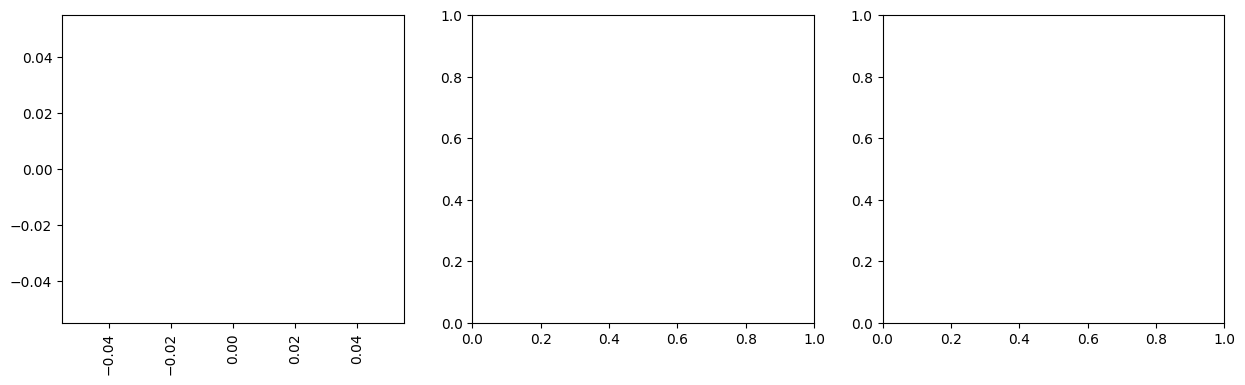

In [158]:
evaluate_coin('ASR-USD')

In [98]:

for n in [1, 2, 12, 24, 48, 96, 200]:
    # ensure we work with a plain Series (MultiIndex-aware DataFrame -> take the first column)
    

_IncompleteInputError: incomplete input (3234800215.py, line 3)

In [58]:
df

Price,Close,High,Low,Open,Volume,return_fwd_1,return_fwd_2,return_fwd_12,return_fwd_24,return_fwd_48,return_fwd_96,return_fwd_200
Ticker,XRP-USD,XRP-USD,XRP-USD,XRP-USD,XRP-USD,,,,,,,
Datetime,,,,,,,,,,,,
2025-11-21 10:30:00+00:00,1.900170,1.900170,1.900170,1.900170,0,0.000769,-0.000029,-0.000416,-0.025731,0.017257,0.027101,0.029090
2025-11-21 10:35:00+00:00,1.901631,1.901631,1.900382,1.900382,17412096,-0.000797,-0.002020,-0.004500,-0.019610,0.023121,0.032384,0.027551
2025-11-21 10:40:00+00:00,1.900115,1.902293,1.900115,1.901929,17241088,-0.001224,-0.001826,-0.006672,-0.000593,0.028005,0.032487,0.028606
2025-11-21 10:45:00+00:00,1.897789,1.899831,1.897789,1.899831,14029824,-0.000603,-0.000841,-0.006633,0.006558,0.024275,0.036523,0.027589
2025-11-21 10:50:00+00:00,1.896645,1.897709,1.895579,1.897709,11040768,-0.000239,0.000050,-0.007777,0.007897,0.027927,0.040637,0.028485
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-20 11:55:00+00:00,1.941759,1.942710,1.941533,1.942710,850432,0.000376,0.001514,NaN,NaN,NaN,NaN,NaN
2025-12-20 12:00:00+00:00,1.942489,1.942489,1.941822,1.941822,0,0.001138,0.001188,NaN,NaN,NaN,NaN,NaN


In [40]:
df['Close'].pct_change(window).shift(-window)

Ticker,XRP-USD
Datetime,
2025-11-21 10:30:00+00:00,0.029090
2025-11-21 10:35:00+00:00,0.027551
2025-11-21 10:40:00+00:00,0.028606
2025-11-21 10:45:00+00:00,0.027589
2025-11-21 10:50:00+00:00,0.028485
...,...
2025-12-20 11:45:00+00:00,NaN
2025-12-20 11:50:00+00:00,NaN
2025-12-20 11:55:00+00:00,NaN


In [ ]:
df[f'return_fwd_{n}'].

Datetime
2025-11-21 10:30:00+00:00   NaN
2025-11-21 10:35:00+00:00   NaN
2025-11-21 10:40:00+00:00   NaN
2025-11-21 10:45:00+00:00   NaN
2025-11-21 10:50:00+00:00   NaN
                             ..
2025-12-20 11:45:00+00:00   NaN
2025-12-20 11:50:00+00:00   NaN
2025-12-20 11:55:00+00:00   NaN
2025-12-20 12:00:00+00:00   NaN
2025-12-20 12:05:00+00:00   NaN
Name: return_fwd_200, Length: 7690, dtype: float64

In [31]:
ma_crossover

Ticker,XRP-USD
Datetime,
2025-11-21 10:30:00+00:00,0
2025-11-21 10:35:00+00:00,0
2025-11-21 10:40:00+00:00,0
2025-11-21 10:45:00+00:00,0
2025-11-21 10:50:00+00:00,0
...,...
2025-12-20 11:45:00+00:00,0
2025-12-20 11:50:00+00:00,0
2025-12-20 11:55:00+00:00,0


In [22]:
(df['Close'] < df['Close'].rolling(20).mean())

Ticker,XRP-USD
Datetime,
2025-11-21 10:30:00+00:00,False
2025-11-21 10:35:00+00:00,False
2025-11-21 10:40:00+00:00,False
2025-11-21 10:45:00+00:00,False
2025-11-21 10:50:00+00:00,False
...,...
2025-12-20 11:45:00+00:00,False
2025-12-20 11:50:00+00:00,False
2025-12-20 11:55:00+00:00,False


<Axes: xlabel='Datetime'>

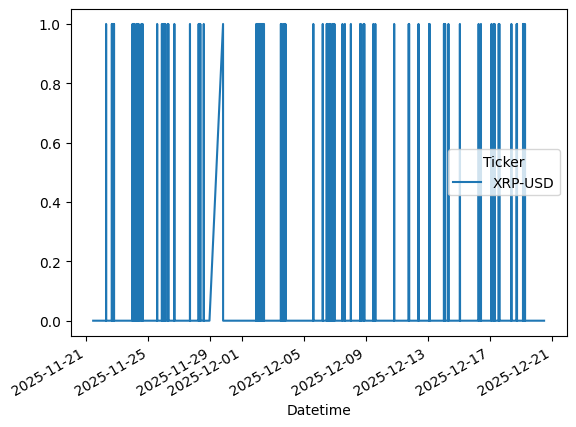